# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: NARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta^{\top}\phi(u_k, x_k) + e_k \, ,$$

where $x_k \in \mathbb{R}^{D}$ is a vector of previous observations and $\theta$ are coefficients. The noise instances $e_k$ are assumed to be zero-mean Gaussian distributed with variance $\sigma^2$.

In [36]:
using Revise
using FFTW
using DSP
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3, margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../NARXsystem.jl"); using .NARXsystem

In [75]:
# Time
N = 256
fs = 20 # Hertz
Δt = 1/fs
tsteps = collect(range(0.0, step=Δt, length=N));

In [76]:
# Define system parameters
sys_mnoise_sd = 1e-2;
input_lims = (-1.,1.)

H = 3
# function sys_basis(x::AbstractVector) 
#     basis = [1.0]
#     for n in 1:length(x)
#         for d in 1:H
#             push!(basis, x[n].^d)
#         end
#     end
#     return basis
# end
# rbf(x, a=0.0, l=1.0) = exp(-(x-a)^2./l)
# sys_basis(x) = cat([1; [rbf(x, a=a) for a in range(-1, stop=1, length=H)]]...,dims=1)
sys_basis(x) = cat([1.0; [x.^d for d in 1:H]]...,dims=1)

M_in = 2
M_out = 2
M = size(sys_basis(zeros(M_out + 1 + M_in)),1);
# sys_coefficients = [0.0; -cos.((1:M-1.)./(π))./2]

df = digitalfilter(Lowpass(1.2; fs=fs), Butterworth(maximum([M_in, M_out])))
sys_coefficients = [0.0; sys_basis([coefb(df)[2:M_out+1]; coefa(df)[1:M_in+1]])[2:end]]

16-element Vector{Float64}:
  0.0
  0.05571953223427204
  0.02785976611713602
  1.0
 -1.475480443592646
  0.5869195080611902
  0.003104666272406081
  0.0007761665681015203
  1.0
  2.1770425394243516
  0.3444745089427895
  0.00017299055244198786
  2.1623819055248483e-5
  1.0
 -3.2121836917899027
  0.20217880932832208

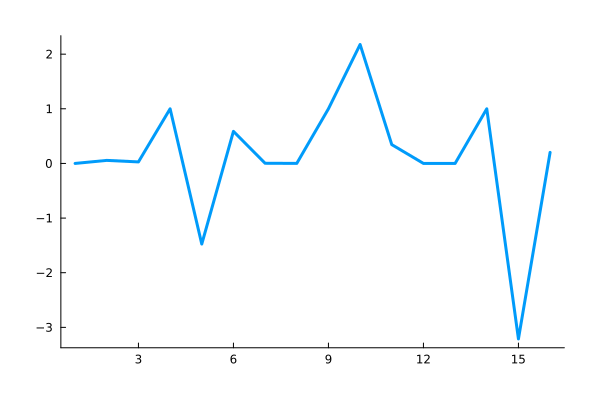

In [77]:
plot(sys_coefficients)

In [78]:
# Inputs
Ω  = rand(5)*10
controls = mean([sin.(ω.*tsteps) for ω in Ω]);
# controls = [0.0; 3*ones(N-1)]

256-element Vector{Float64}:
  0.0
  0.2708133704024541
  0.5061594716690903
  0.6759184506773914
  0.7598473533638794
  0.7505992958997598
  0.6547717323816127
  0.4918255863093767
  0.29104344066498156
  0.08699530221974712
  ⋮
 -0.15075124851467028
 -0.060904050262471796
  0.06281930187241323
  0.2059462308119347
  0.3507925586776553
  0.4790904214790512
  0.5747160411686106
  0.626100879358013
  0.6279574333395319

In [79]:
# Outputs
system = NARXsys(sys_coefficients, sys_basis, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in, input_lims=input_lims)

outputs = zeros(N)
inputs = zeros(N)
for k in 1:N
    NARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

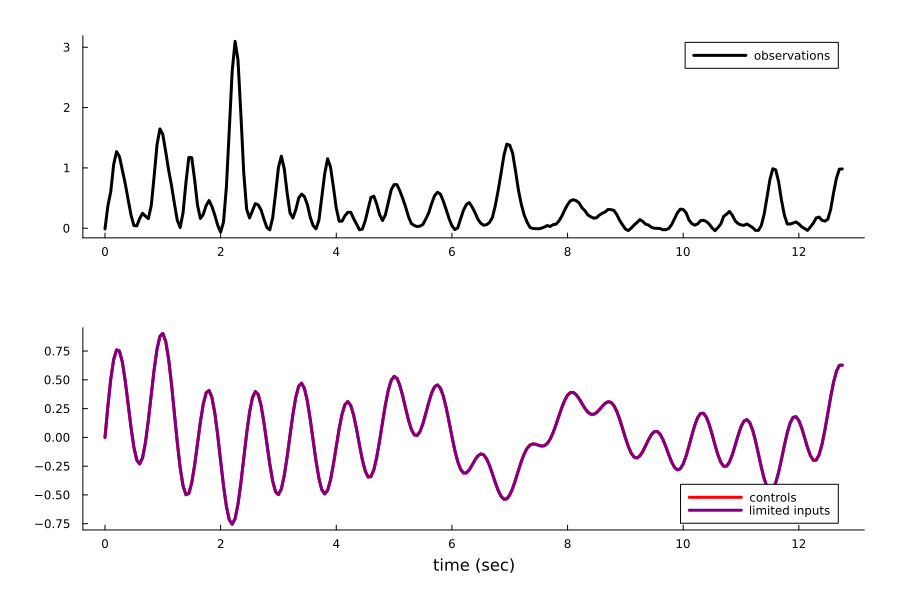

In [80]:
p101 = plot(tsteps, outputs, color="black", label="observations")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="limited inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

## NARX parameter estimation

In [81]:
# Polynomial degree
H = 3

# Delay order
Ly = M_in
Lu = M_out

# Model order
M = size(pol(zeros(1+Ly+Lu), degree=H),1);

In [82]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 1e2diagm(ones(M)))
goal = NormalMeanVariance(sqrt(2)/2, 1e-3)

agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0]
)
, GammaShapeRate{Float64}(a=100.0, b=1.0), NormalMeanVariance{Float64}(μ=0.7071067811865476, v=0.001), 1, 10, 0.0, 2, 2, 3, 16, [0.0, 0.0], [0.0, 0.0, 0.0])

In [83]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(10,N)

T = 10
@showprogress for k in 1:(N-T)
    
    # Make predictions
    push!(py, predictions(agent, inputs[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], inputs[k])
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)
    
    # Evaluate
    FE[:,k] = agent.free_energy
end

Progress:  26%|██████████▌                              |  ETA: 0:00:00

Progress:  73%|██████████████████████████████           |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


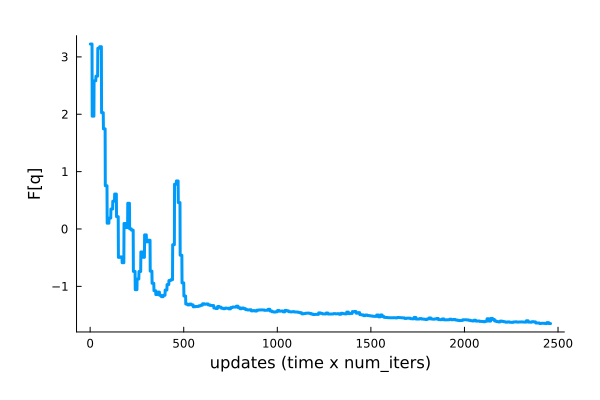

In [84]:
plot(reshape(FE[:,1:(N-T)], (10*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

In [85]:
vθ = cat( var.(qθ)...,dims=2)
mθ = cat(mean.(qθ)...,dims=2)

16×247 Matrix{Float64}:
 0.0  -0.0114263  -0.0109453    -0.0109032   …  -0.00132785   -0.00134256
 0.0   0.0        -0.0549731    -0.230561        0.0106935     0.0104093
 0.0   0.0         0.0           0.00510635      0.0357193     0.0358034
 0.0   0.0         1.30278       1.31167         1.04413       1.04414
 0.0   0.0         0.0          -0.121013       -1.5372       -1.53706
 0.0   0.0         0.0           0.0         …   0.604695      0.604564
 0.0   0.0         0.000628201  -0.0606796       0.00454516    0.0045553
 0.0   0.0         0.0          -5.83525e-5     -0.00476711   -0.00483713
 0.0   0.0         0.352811      0.301989        1.04887       1.04915
 0.0   0.0         0.0          -0.0327719       2.10791       2.10761
 0.0   0.0         0.0           0.0         …   0.527958      0.529009
 0.0   0.0        -7.17873e-6   -0.0227802       0.00101523    0.00101408
 0.0   0.0         0.0           6.66819e-7      0.000747605   0.000763585
 0.0   0.0         0.0955458    

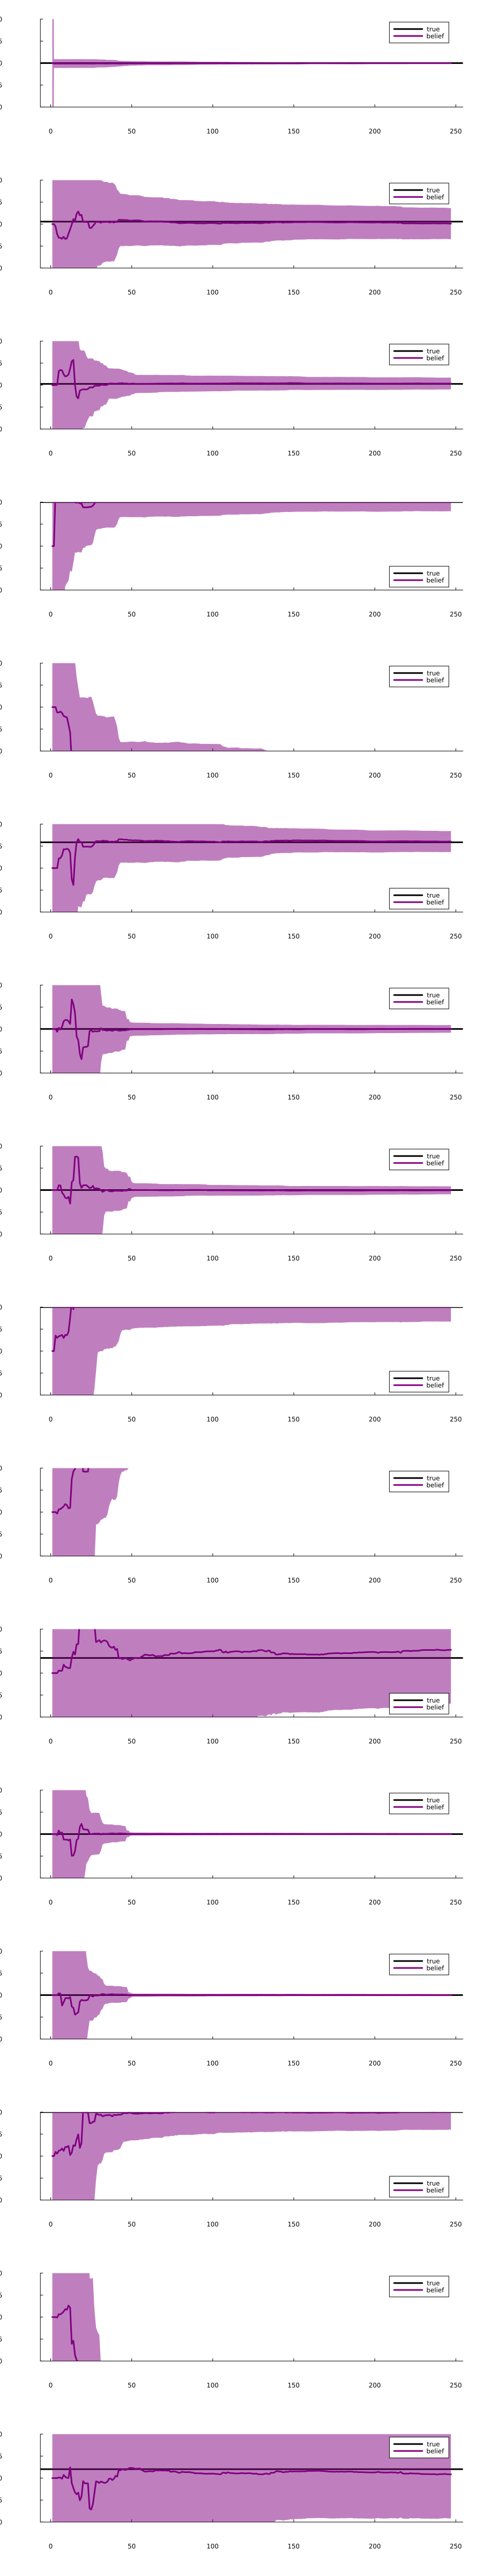

In [86]:
pw = []
for m in 1:M
    pwm = plot(ylims=(-1.,1.))
    
    hline!([sys_coefficients[m]], color="black", label="true")
    plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", label="belief", ylabel="θ_$m")
    
    push!(pw,pwm)
end
plot(pw..., layout=(M,1), size=(900,M*300))

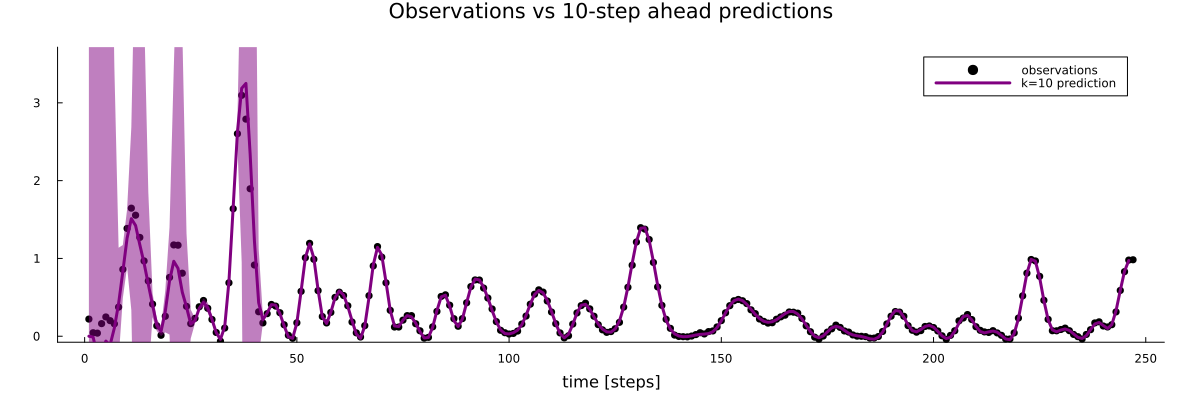

In [87]:
limsb = [minimum(outputs)*1.2, maximum(outputs)*1.2]
K = 10

p1 = plot(xlabel="time [steps]", title="Observations vs $K-step ahead predictions", ylims=limsb, size=(1200,400))
scatter!(outputs[K:end], color="black", label="observations")
plot!([py[k][1][K] for k in 1:(N-T)], ribbon=[py[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")

## Experiments

In [89]:
# Length of trial
N = 100
tsteps = range(0.0, step=Δt, length=N)
T = 5

# Orders
H = 3
Ly = M_in
Lu = M_out
M = size(pol(zeros(1+Ly+Lu), degree=H),1);

# Set control properties
goal = NormalMeanVariance(sqrt(2)/2, 1e-4)
control_prior = 0.0
num_iters = 10
u_lims = (-1., 1.)
tlimit = 10

# Specify prior distributions
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 1e2diagm(ones(M)))

MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0]
)


### Expected Free Energy minimization

In [127]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+T)
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]
py_EFE = []
FE_EFE = zeros(num_iters, N)
start = 10
goals = [NormalMeanVariance(mean(goal), Inf) for t in 1:start]
gvars = 10 .^range(3, stop=-6, length=N)

@showprogress for k in 1:N
    
    # Act upon environment
    NARXsystem.update!(system, u_EFE[k])
    y_EFE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    FE_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)
    
    # Move goal closer
    goal_k = NormalMeanVariance(mean(goal), gvars[k])
    update_goals!(goals, goal_k)
    agent.goals = goals
    
    # Optimal control
    policy = minimizeEFE(agent, goals, time_limit=tlimit, control_lims=u_lims)
    u_EFE[k+1:k+T] = policy
    
    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))
    
end

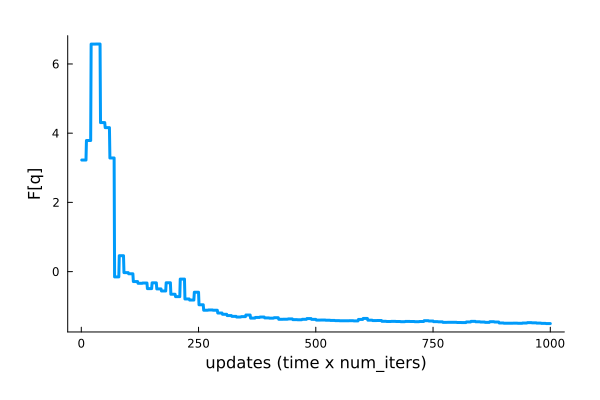

In [97]:
plot(FE_EFE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

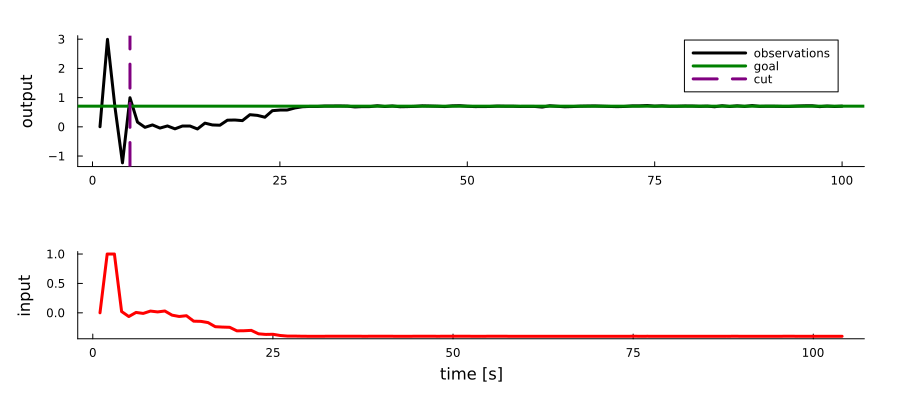

In [104]:
p1 = plot(y_EFE, color="black", label="observations", ylabel="output")
hline!([mean(goal)], color="green", label="goal")
vline!([T], color="purple", linestyle=:dash, label="cut")
p4 = plot(u_EFE[1:end-1], color="red", ylabel="input", yticks=[0.0, 0.5, 1.0], xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.6, .4]), size=(900,400))

In [105]:
savefig("figures/NARX-EFE-verification-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-verification-trial.png"

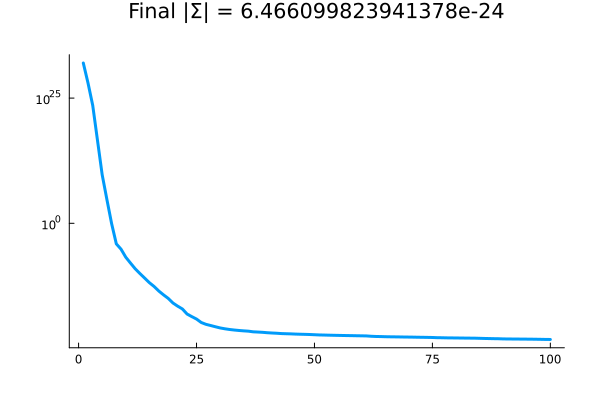

In [106]:
dSθ_EFE = [det(cov(pθ_EFE[k])) for k in 1:N]
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-verification-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-verification-planning.gif")
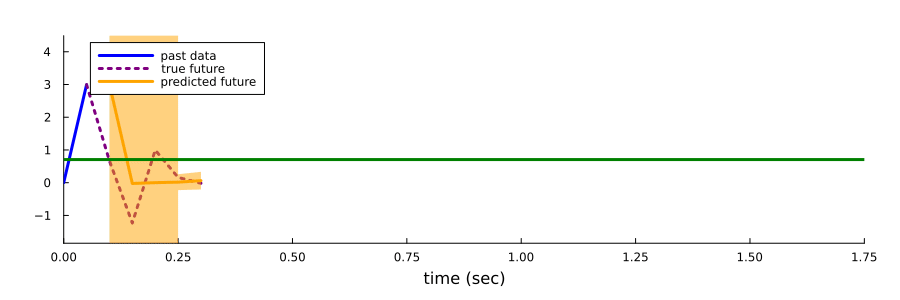

In [107]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-verification-planning.gif", fps=24)

### Mean Squared Error minimization

In [108]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in,
                 input_lims=input_lims)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+T)
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]
py_MSE = []
FE_MSE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    NARXsystem.update!(system, u_MSE[k])
    y_MSE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    FE_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)
    
    # Optimal control
    policy = minimizeMSE(agent, [goal for t in 1:T], time_limit=tlimit, control_lims=u_lims)
    u_MSE[k+1] = policy[1]
    
    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   2%|▉                                        |  ETA: 0:01:13

Progress:   8%|███▎                                     |  ETA: 0:01:01

Progress:  11%|████▌                                    |  ETA: 0:00:44

Progress:  13%|█████▍                                   |  ETA: 0:00:56

Progress:  15%|██████▏                                  |  ETA: 0:00:48

Progress:  16%|██████▌                                  |  ETA: 0:00:56

Progress:  17%|███████                                  |  ETA: 0:00:55

Progress:  18%|███████▍                                 |  ETA: 0:00:52

Progress:  19%|███████▊                                 |  ETA: 0:00:49

Progress:  21%|████████▋                                |  ETA: 0:00:44

Progress:  24%|█████████▉                               |  ETA: 0:00:38

Progress:  34%|██████████████                           |  ETA: 0:00:24

Progress:  44%|██████████████████                       |  ETA: 0:00:16

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:11

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:07

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:04

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:02

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


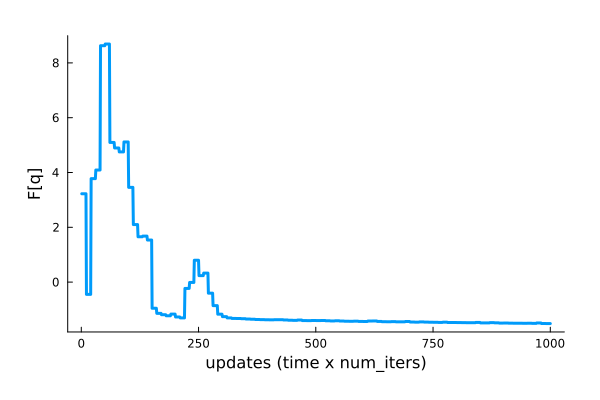

In [109]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

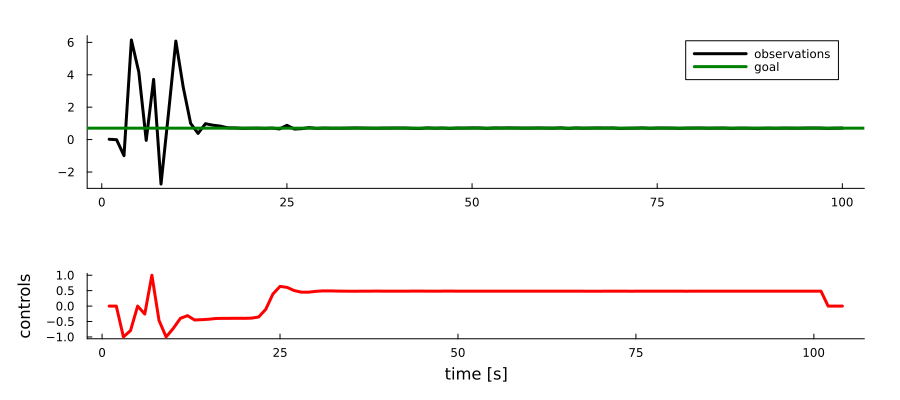

In [110]:
p1 = plot(y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(u_MSE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [111]:
savefig("figures/NARX-MSE-verification-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-verification-trial.png"

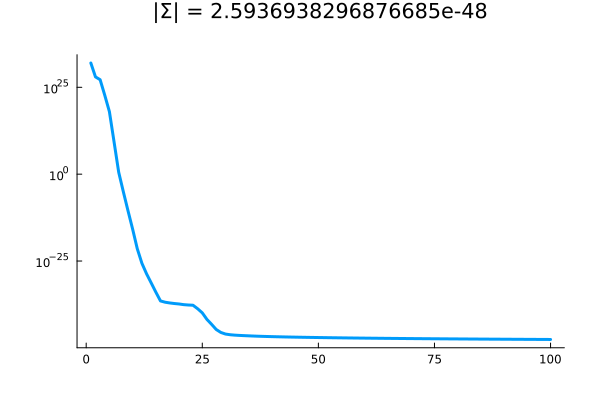

In [112]:
dSθ_MSE = [det(cov(pθ_MSE[k])) for k in 1:N]
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="|Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-verification-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-verification-planning.gif")
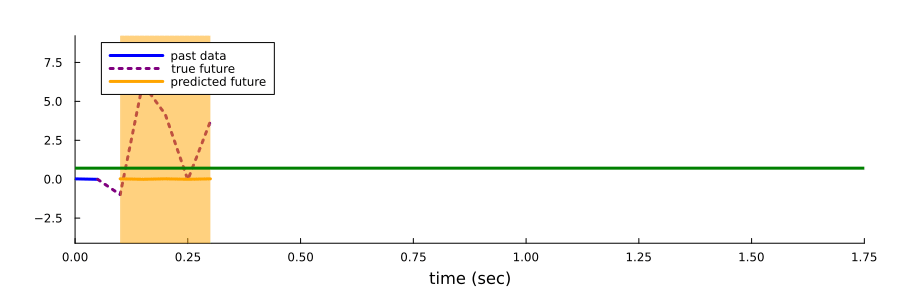

In [113]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]
window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-verification-planning.gif", fps=24)

### Comparison

In [114]:
println("Final |Σ| MSE = $final_dSθ_MSE")
println("Final |Σ| EFE = $final_dSθ_EFE")

Final |Σ| MSE = 2.5936938296876685e-48
Final |Σ| EFE = 6.466099823941378e-24


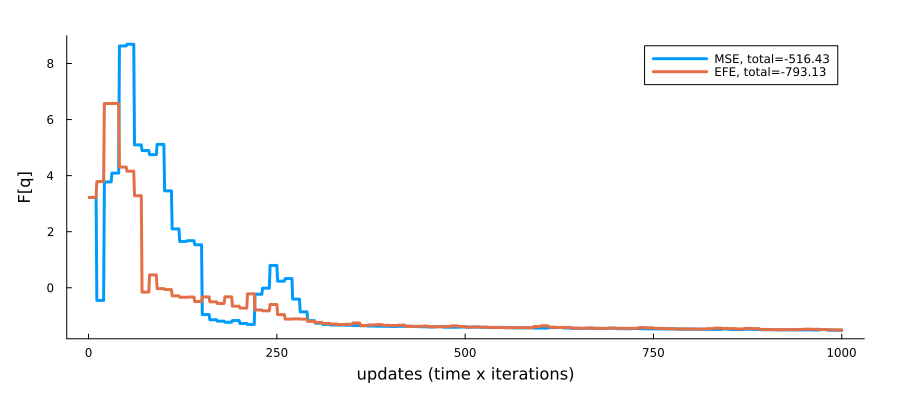

In [115]:
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")

In [124]:
Normal(py_MSE[1][1][1], py_MSE[1][2][1])

Normal{Float64}(μ=0.020935203935071773, σ=0.06449701923963914)

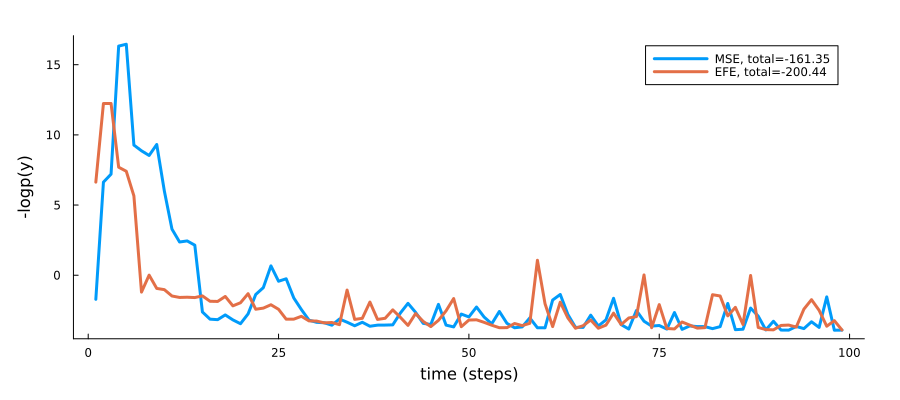

In [125]:
evidence_MSE = [-logpdf(Normal(py_MSE[k][1][1], py_MSE[k][2][1]), y_MSE[k+1]) for k in 1:(N-1)]
evidence_EFE = [-logpdf(Normal(py_EFE[k][1][1], py_EFE[k][2][1]), y_EFE[k+1]) for k in 1:(N-1)]

total_evidence_MSE = round(sum(evidence_MSE), digits=2)
total_evidence_EFE = round(sum(evidence_EFE), digits=2)

plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

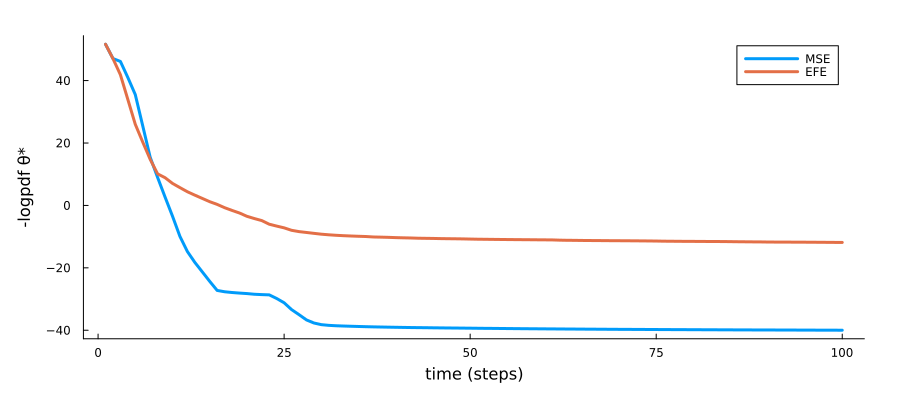

In [117]:
idθ_MSE = [-logpdf(pθ_MSE[k], sys_coefficients) for k in 1:N]
idθ_EFE = [-logpdf(pθ_EFE[k], sys_coefficients) for k in 1:N]

plot(xlabel="time (steps)", ylabel="-logpdf θ*", size=(900,400))
plot!(idθ_MSE, label="MSE")
plot!(idθ_EFE, label="EFE")

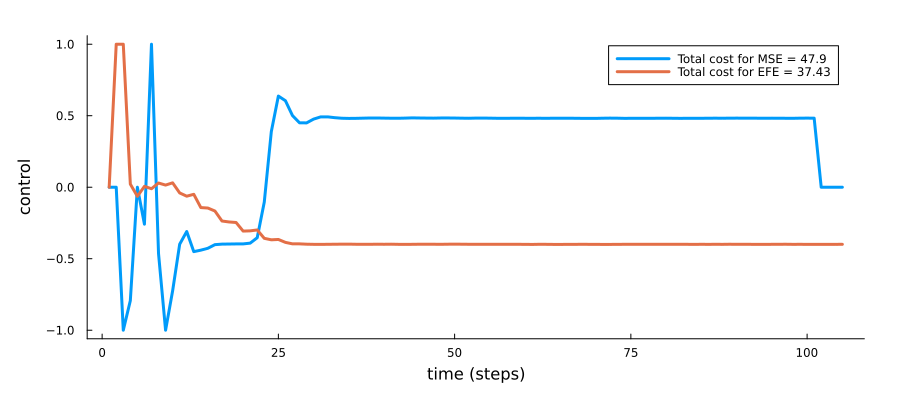

In [118]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

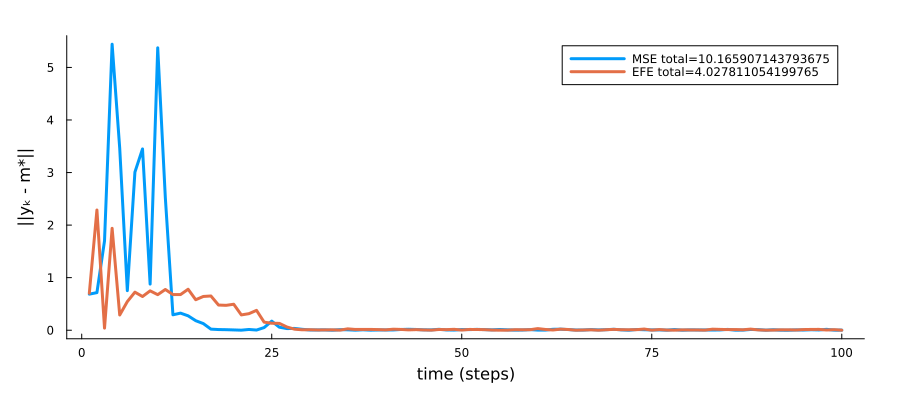

In [119]:
J_MSE = [norm(y_MSE[k] - mean(goal),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goal),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goal),2)
sJ_EFE = norm(y_EFE .- mean(goal),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")